In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "
/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
nemo = xr.open_dataset('/home/bruno/git/pnas/nemo_data/pnas2014to2021.nc')
nemo = nemo.reindex()
nemo.close()

In [6]:
nemo1 = xr.open_dataset('/home/bruno/git/pnas/nemo_data/sst_sites_2021to2023.nc')
nemo1 = nemo1.reindex()
nemo1.close()

1. Explorar as Dimensões Depth e Coordenadas
##### Verifique as dimensões e coordenadas principais dos arquivos:

In [4]:
print(nemo.dims)
print(nemo.coords)


Frozen({'depth': 21, 'latitude': 331, 'longitude': 216, 'time': 90})
Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 5.078 ... 65.81 77.85 92.33
  * latitude   (latitude) float32 -25.5 -25.42 -25.33 -25.25 ... 1.833 1.917 2.0
  * longitude  (longitude) float32 -46.0 -45.92 -45.83 ... -28.25 -28.17 -28.08
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01


In [7]:
print(nemo1.dims)
print(nemo1.coords)

Frozen({'depth': 22, 'latitude': 325, 'longitude': 192, 'time': 30})
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 65.81 77.85 92.33
  * latitude   (latitude) float32 -25.0 -24.92 -24.83 -24.75 ... 1.833 1.917 2.0
  * longitude  (longitude) float32 -44.0 -43.92 -43.83 ... -28.25 -28.17 -28.08
  * time       (time) datetime64[ns] 2021-07-01 2021-08-01 ... 2023-12-01


#### 2. Verificar a Série Temporal Confira as datas disponíveis

In [8]:
#Para verificar intervalos:

print(nemo['time'].min().values)
print(nemo['time'].max().values)


2014-01-01T00:00:00.000000000
2021-06-01T00:00:00.000000000


In [9]:
#Para verificar intervalos:

print(nemo1['time'].min().values)
print(nemo1['time'].max().values)

2021-07-01T00:00:00.000000000
2023-12-01T00:00:00.000000000


#### 4. Explorar as Variáveis Liste as variáveis disponíveis:

In [11]:
print(nemo.data_vars)
print(nemo1.data_vars)


Data variables:
    thetao   (time, depth, latitude, longitude) float32 ...
Data variables:
    thetao   (time, depth, latitude, longitude) float32 ...


In [ ]:
##### Concatenando os dois datasets.

In [14]:

# Concatenar os datasets ao longo da dimensão 'time'
combined_ds = xr.concat([nemo, nemo1], dim='time')

In [15]:
#Para verificar intervalos:

print(combined_ds['time'].min().values)
print(combined_ds['time'].max().values)

2014-01-01T00:00:00.000000000
2023-12-01T00:00:00.000000000


#### Mapa de localização pontos bruv

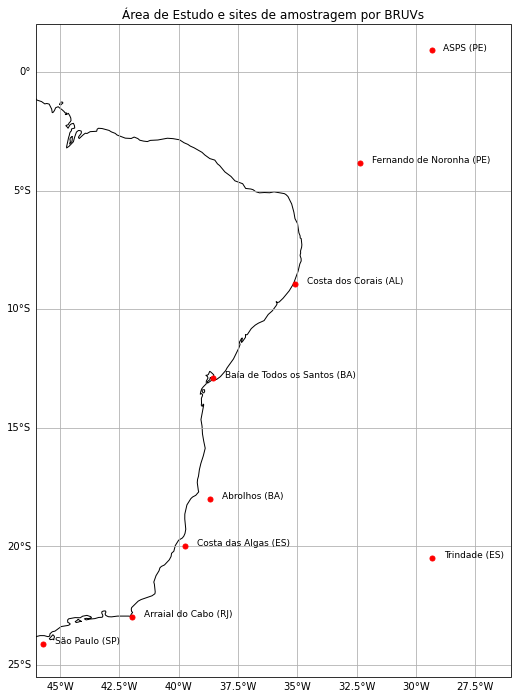

In [16]:
# Extraindo as coordenadas de latitude e longitude do dataset
lats = combined_ds['latitude'].values
lons = combined_ds['longitude'].values

# Criando o  Dicionário de localizações
localizacoes = {
    "Abrolhos (BA)": (-18, -38.67),
    "Costa das Algas (ES)": (-19.99, -39.745),
    "Costa dos Corais (AL)": (-8.92, -35.11),
    "Arraial do Cabo (RJ)": (-22.99, -41.97),
    "ASPS (PE)": (0.91, -29.34),
    "Baía de Todos os Santos (BA)": (-12.90, -38.56),
    "Fernando de Noronha (PE)": (-3.83, -32.34),
    "São Paulo (SP)": (-24.11, -45.72),
    "Trindade (ES)": (-20.50, -29.30)
}

# Criar a figura e os subplots
fig = plt.figure(figsize=(10, 12))

# Mapa principal: Área de estudo
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.set_extent([lons.min(), -26, lats.min(), lats.max()])  # Ajuste para incluir até 26°W
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax1.set_title('Área de Estudo e sites de amostragem por BRUVs')

# Adicionar pontos de localização e labels no mapa principal
for local, (lat, lon) in localizacoes.items():
    ax1.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
    ax1.text(lon + 0.5, lat, local, fontsize=9, transform=ccrs.PlateCarree())

plt.show()


### Criando subset em netcdf para cada ponto do mapa anterior

O parâmetro buffer no código define um raio de busca ao redor de cada ponto de latitude e longitude. Ele expande a área de interesse para incluir dados adjacentes à localização central, considerando uma faixa ao redor do ponto especificado.

No exemplo, o buffer está ajustado para 0.5 graus, o que significa que o subset incluirá dados em uma faixa de ±0.5 graus tanto na latitude quanto na longitude. Esse valor pode ser ajustado conforme necessário para ampliar ou reduzir a área ao redor de cada ponto. Um buffer maior cobre uma área mais ampla, enquanto um buffer menor foca em áreas mais localizadas.
#### Exemplo:

 Se uma localização tiver coordenadas (lat=-18, lon=-38.67) e um buffer de 0.5, o subset incluirá dados entre as latitudes de -18.5 a -17.5 e longitudes de -39.17 a -38.17

In [17]:
subsets = {}

# Definir um raio de busca em torno de cada localização (em graus)
buffer = 0.5  # Ajuste esse valor conforme necessário

# Iterar sobre as localizações e criar subsets
for local, (lat, lon) in localizacoes.items():
    subset = nemo.sel(latitude=slice(lat-buffer, lat+buffer), longitude=slice(lon-buffer, lon+buffer))
    subsets[local] = subset  # Armazena o subset no dicionário
    
    # Exemplo de visualização rápida
    print(f"Subset para {local}:")
    print(subset)

Subset para Abrolhos (BA):
<xarray.Dataset>
Dimensions:    (depth: 21, latitude: 13, longitude: 12, time: 90)
Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 5.078 ... 65.81 77.85 92.33
  * latitude   (latitude) float32 -18.5 -18.42 -18.33 ... -17.67 -17.58 -17.5
  * longitude  (longitude) float32 -39.17 -39.08 -39.0 ... -38.42 -38.33 -38.25
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             Monthly mean fields for product GLOBAL_REANALYSIS_PHY_...
    institution:       Mercator Ocean
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MERCATOR GLORYS12V1
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    subset:source:     ARCO d

### Criando uma váriavel subset para cada localização

In [24]:

# Acessando o subset de "Abrolhos (BA)" e suas variáveis
abrolhos_subset = subsets["Abrolhos (BA)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
algas_subset = subsets["Costa das Algas (ES)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
corais_subset = subsets["Costa dos Corais (AL)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
acabo_subset = subsets["Arraial do Cabo (RJ)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
asps_subset = subsets["ASPS (PE)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
bsantos_subset = subsets["Baía de Todos os Santos (BA)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
fnoronha_subset = subsets["Fernando de Noronha (PE)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
sp_subset = subsets["São Paulo (SP)"]
# Acessando o subset de "Abrolhos (BA)" e suas variáveis
trind_subset = subsets["Trindade (ES)"]

In [29]:
asps_subset

<xarray.Dataset>
Dimensions:    (depth: 21, latitude: 12, longitude: 12, time: 90)
Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 5.078 ... 65.81 77.85 92.33
  * latitude   (latitude) float32 0.4167 0.5 0.5833 0.6667 ... 1.167 1.25 1.333
  * longitude  (longitude) float32 -29.83 -29.75 -29.67 ... -29.08 -29.0 -28.92
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2021-06-01
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             Monthly mean fields for product GLOBAL_REANALYSIS_PHY_...
    institution:       Mercator Ocean
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MERCATOR GLORYS12V1
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_PHY_001_030
    subset:datasetId:  cmems_mod_glo_phy_my_0.083deg_P1M-m_202311
    subset:date:       2024-10-01T12:52:03.827Z

In [ ]:
# Acessando a váriavel "thetao" em cada subset
abrolhos_tao = abrolhos_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
algas_tao = algas_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
corais_tao = corais_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
acabo_tao = acabo_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
asps_tao = asps_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
bsantos_tao = bsantos_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
fnoronha_tao = fnoronha_subset['thetao']
# Acessando a váriavel "thetao" em cada subset
sp_tao =sp_subset['thetao']
# Acessando a váriavel"thetao" em cada subset
trind_tao = trind_subset['thetao']

## 5. Visualização de Dados
Plote um gráfico simples para ver a amplitude dos dados e variações temporais:em todos os locais

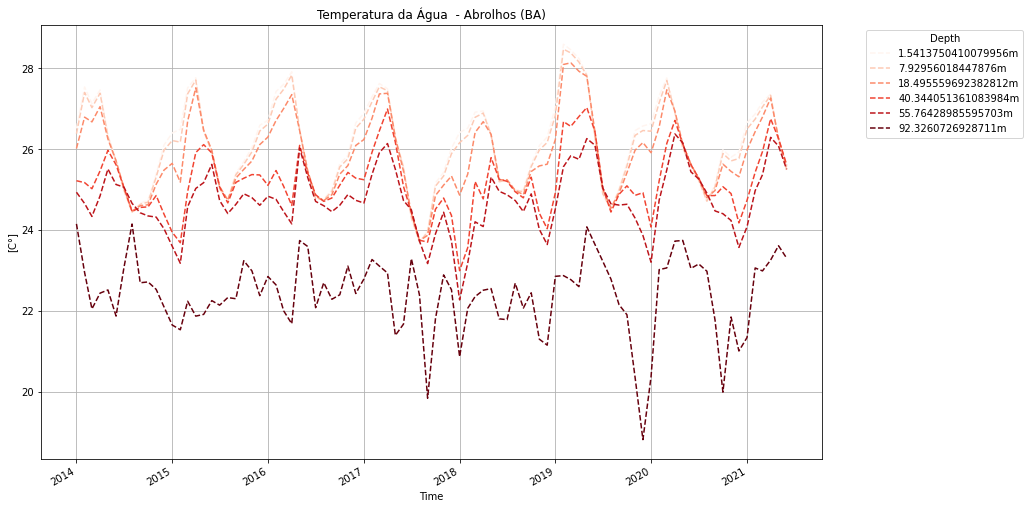

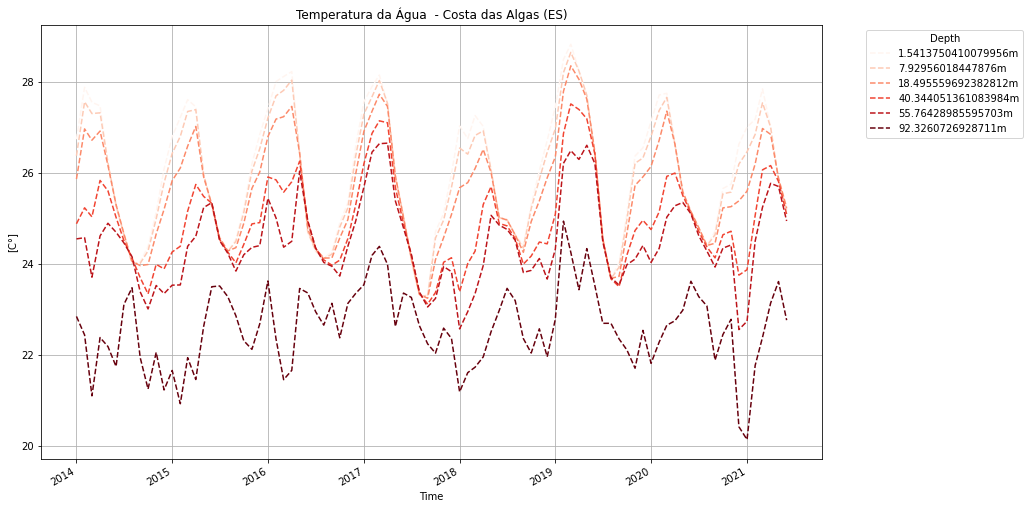

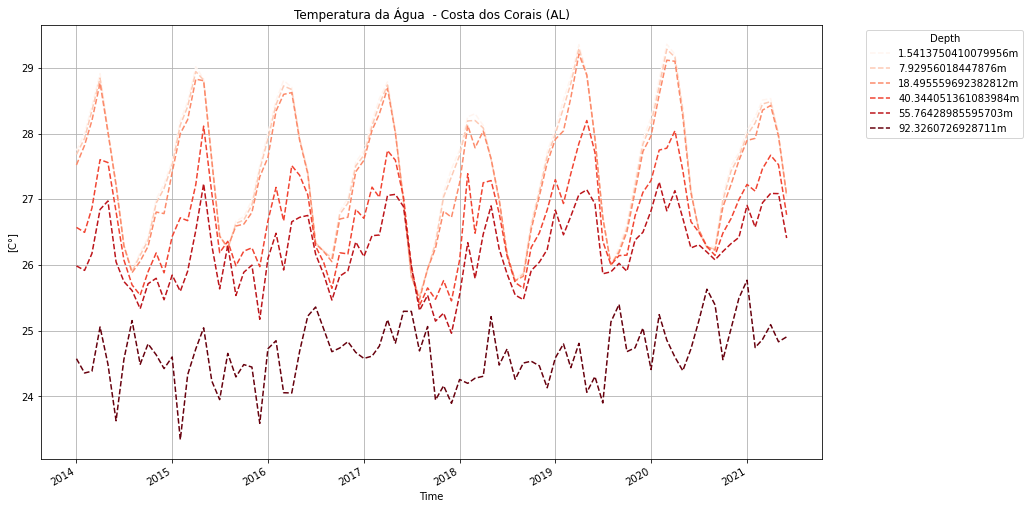

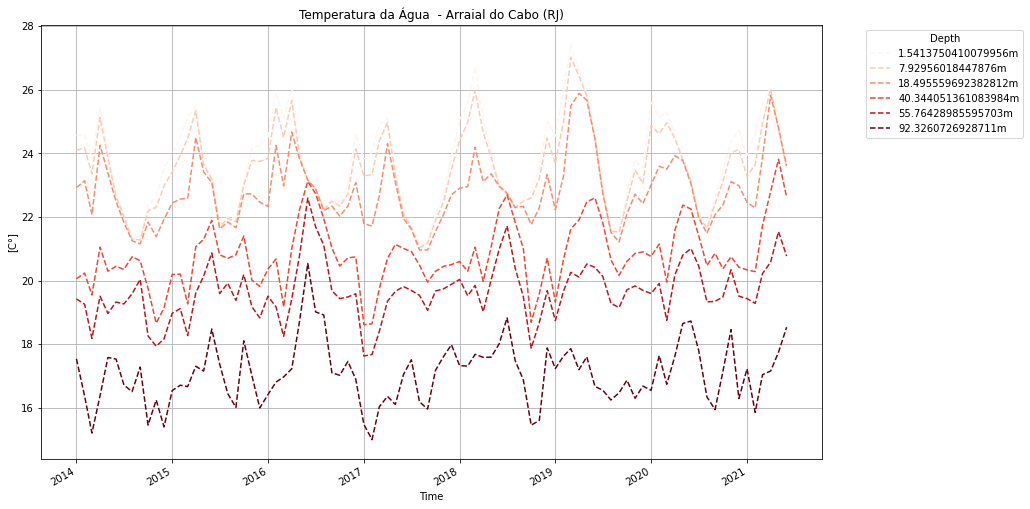

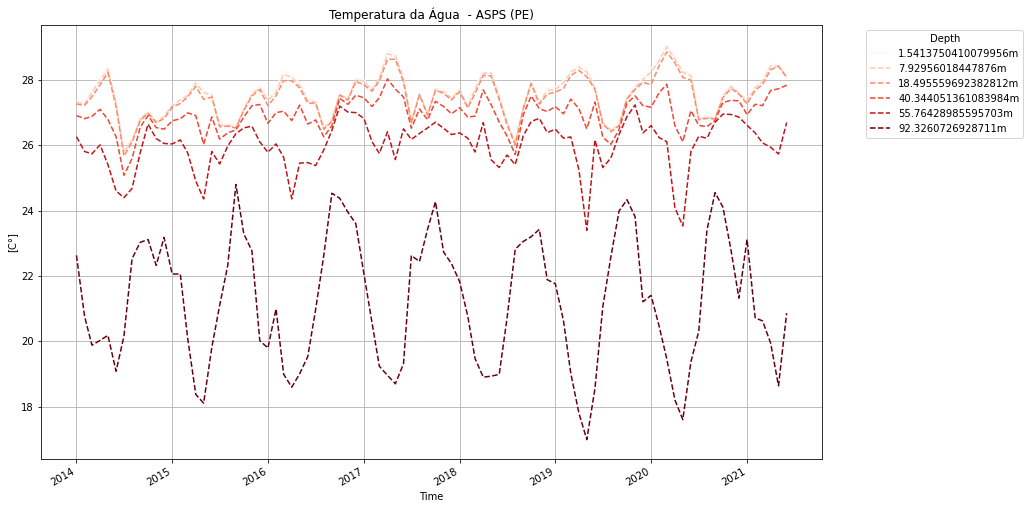

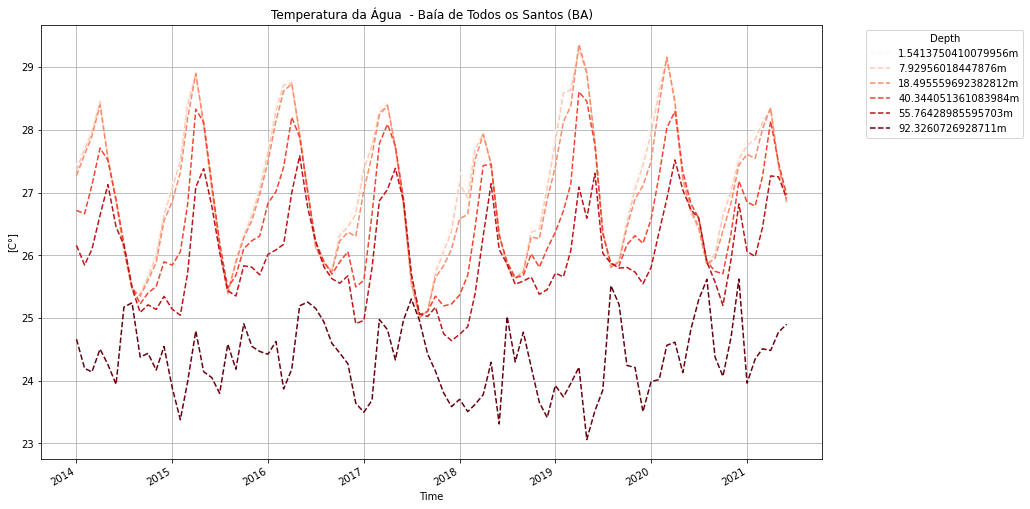

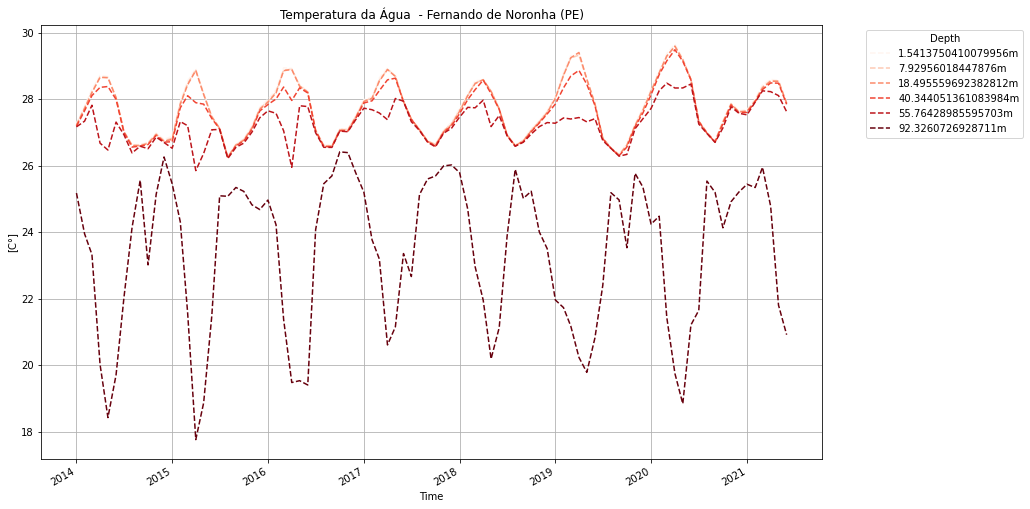

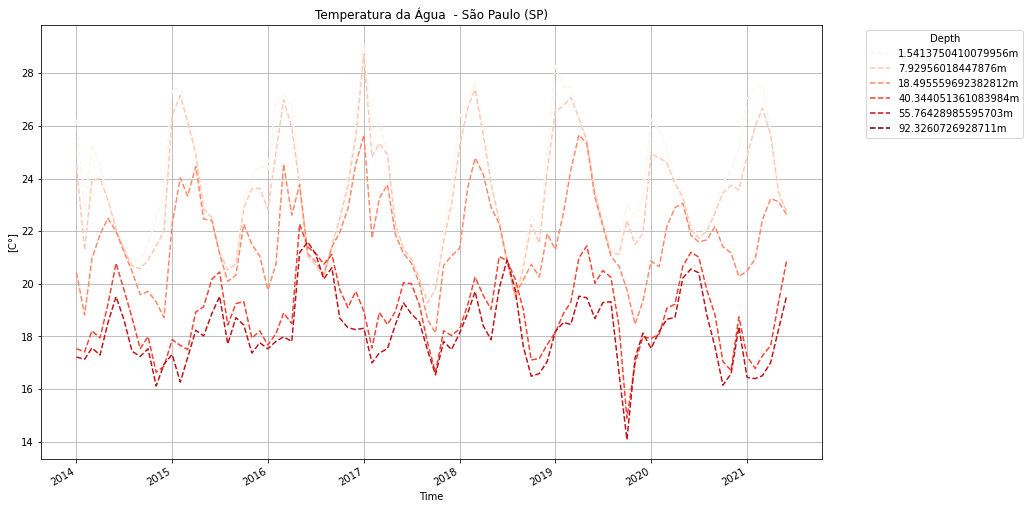

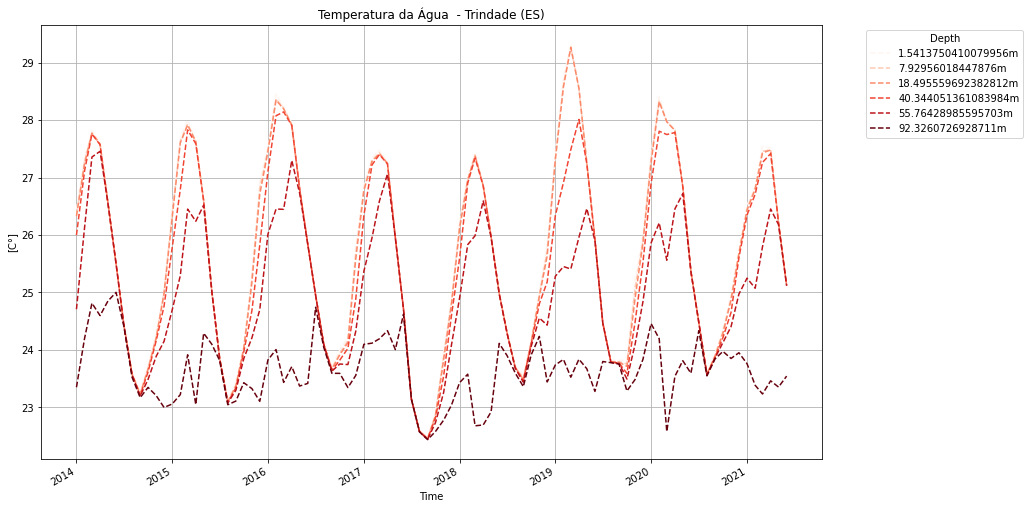

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Loop para gerar gráficos para cada local de interesse
for local, subset in subsets.items():
    # Configurar a figura
    plt.figure(figsize=(14, 8))

    # Profundidades reais correspondentes aos índices
    depth_indices = [0, 5, 10, 15, 17, 20]
    depths = subset['depth'].isel(depth=depth_indices).values
    colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Gera uma lista de cores para variação de temperatura

    # Iterar sobre as profundidades e plotar em um único gráfico para cada subset
    for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
        subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(label=f'{depth}m',
                                                                                   color=color, linestyle='--')

    # Configurar o gráfico
    plt.title(f'Temperatura da Água  - {local}')
    plt.xlabel('Time')
    plt.ylabel('[C°]')
    plt.grid(True)

    # Colocar a legenda fora da figura
    plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Exibir o gráfico
    plt.show()


In [26]:
aspsp_subset

NameError: name 'aspsp_subset' is not defined

#### 5.1 Aqui fizemos plots separados para cada site

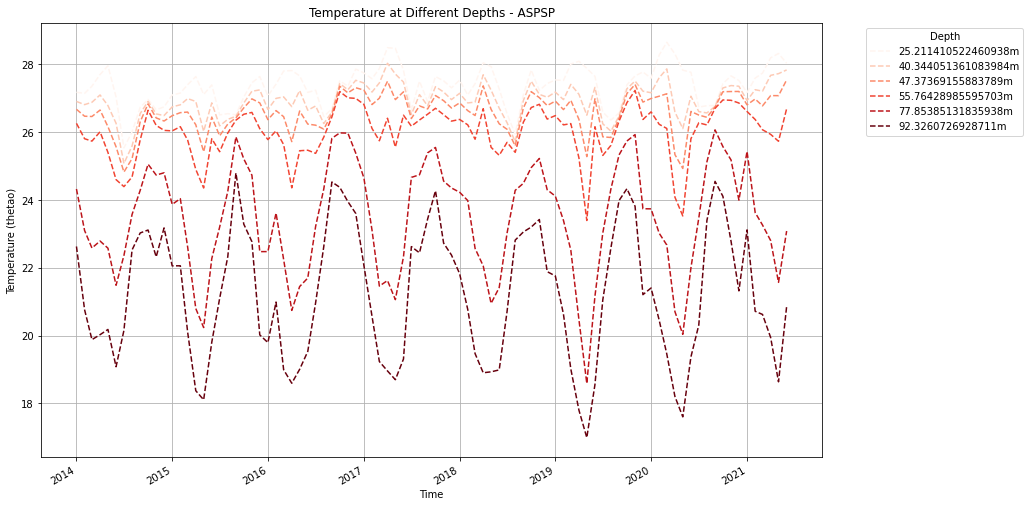

In [36]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [12, 15, 16, 17, 19, 20]
depths = asps_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    asps_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - ASPSP (PE)')
plt.xlabel('Time')
plt.ylabel('[C°]]')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()


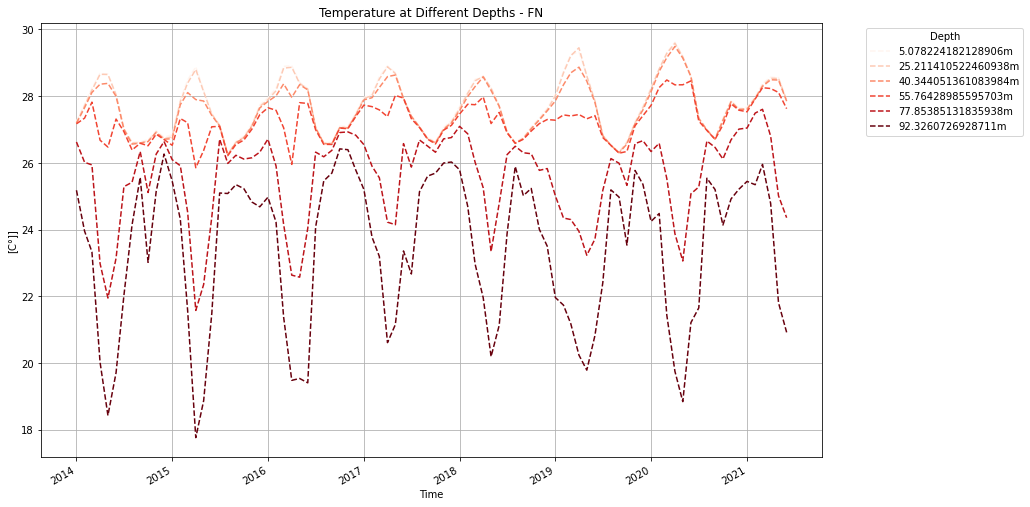

In [45]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [3, 12, 15, 17, 19, 20]
depths = fnoronha_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    fnoronha_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - FN')
plt.xlabel('Time')
plt.ylabel('[C°]]')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()


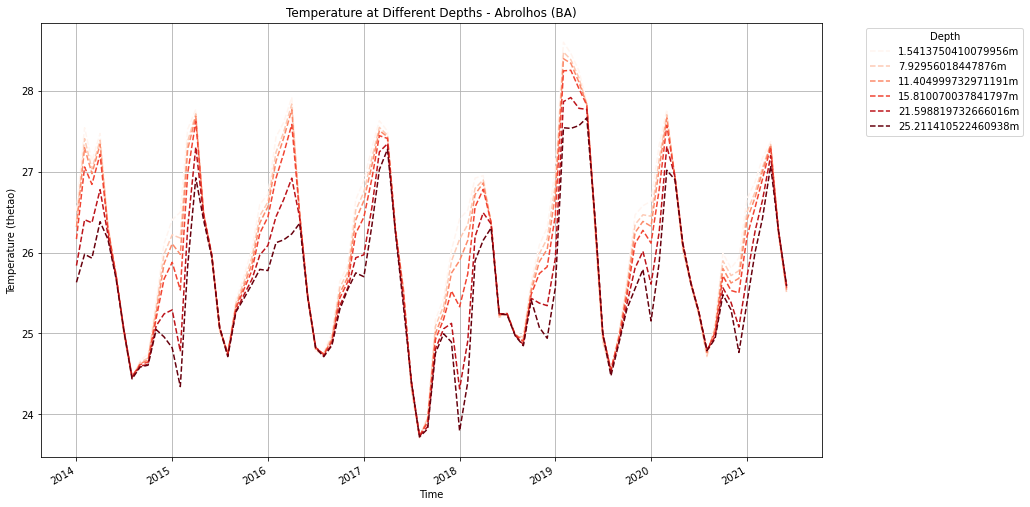

In [52]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [0, 5, 7, 9, 11, 12]
depths = abrolhos_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    abrolhos_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - Abrolhos (BA)')
plt.xlabel('Time')
plt.ylabel('Temperature (thetao)')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

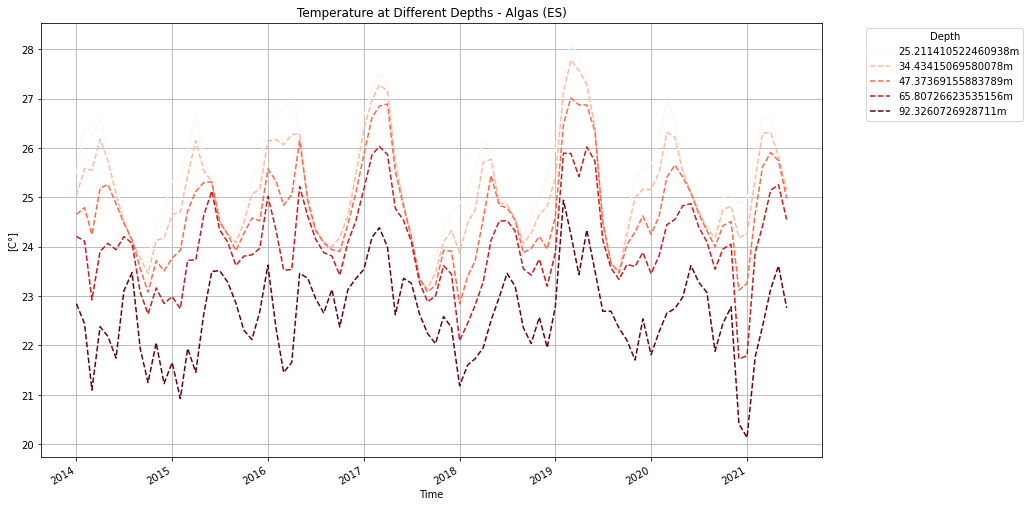

In [57]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [12, 14, 16, 18, 20]
depths = algas_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    algas_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - Algas (ES)')
plt.xlabel('Time')
plt.ylabel('[C°]')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

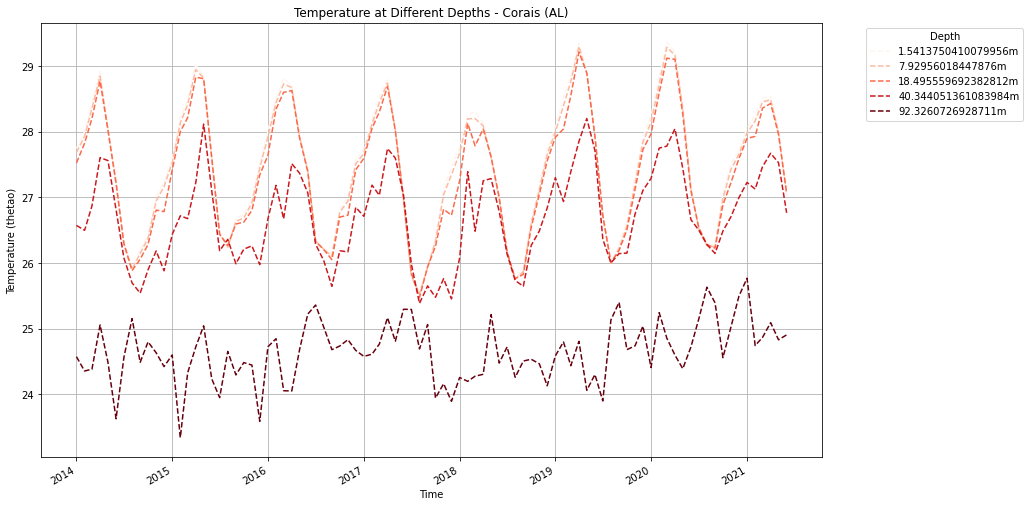

In [59]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [0, 5, 10, 15, 20,]
depths = corais_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    corais_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - Corais (AL)')
plt.xlabel('Time')
plt.ylabel('Temperature (thetao)')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

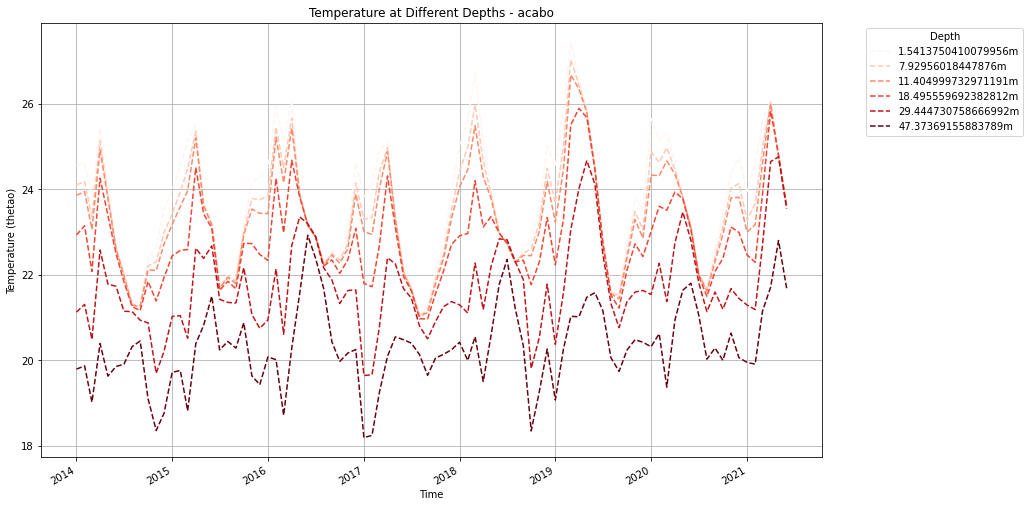

In [63]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [0, 5, 7, 10, 13, 16]
depths = acabo_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    acabo_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - Arraial do Cabo')
plt.xlabel('Time')
plt.ylabel('Temperature (thetao)')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

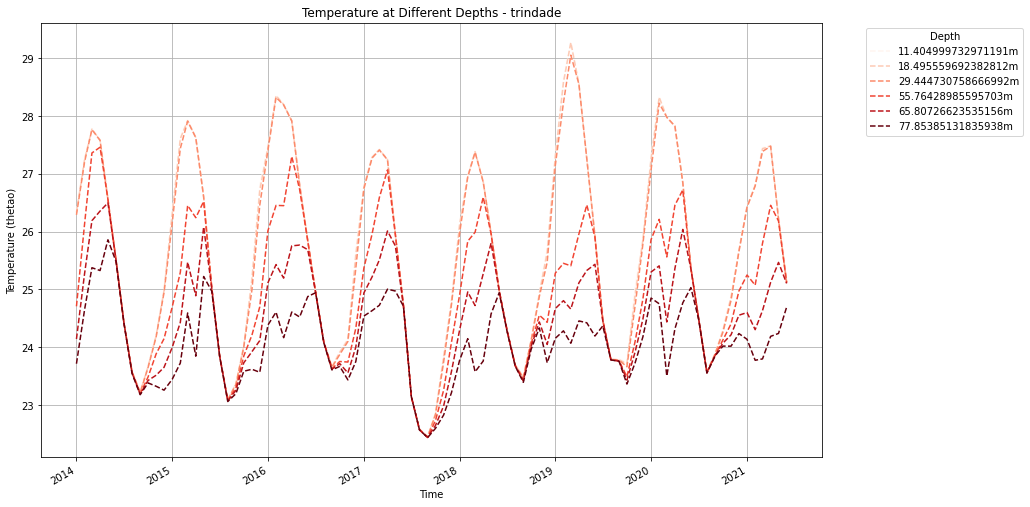

In [74]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [7, 10, 13, 17, 18, 19]
depths = trind_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    trind_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - Trindade')
plt.xlabel('Time')
plt.ylabel('Temperature (thetao)')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

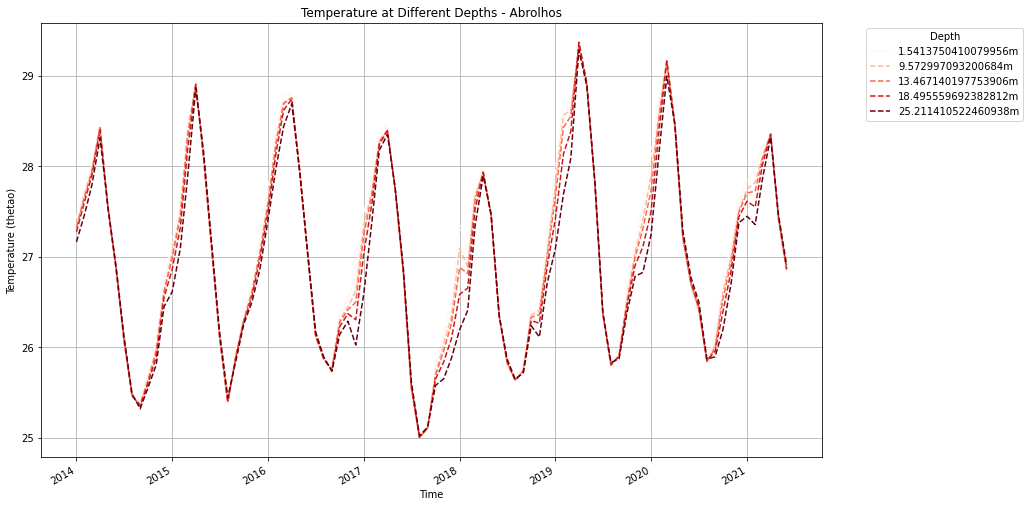

In [77]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [0, 6, 8, 10, 12,]
depths = bsantos_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    bsantos_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - Abrolhos')
plt.xlabel('Time')
plt.ylabel('Temperature (thetao)')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

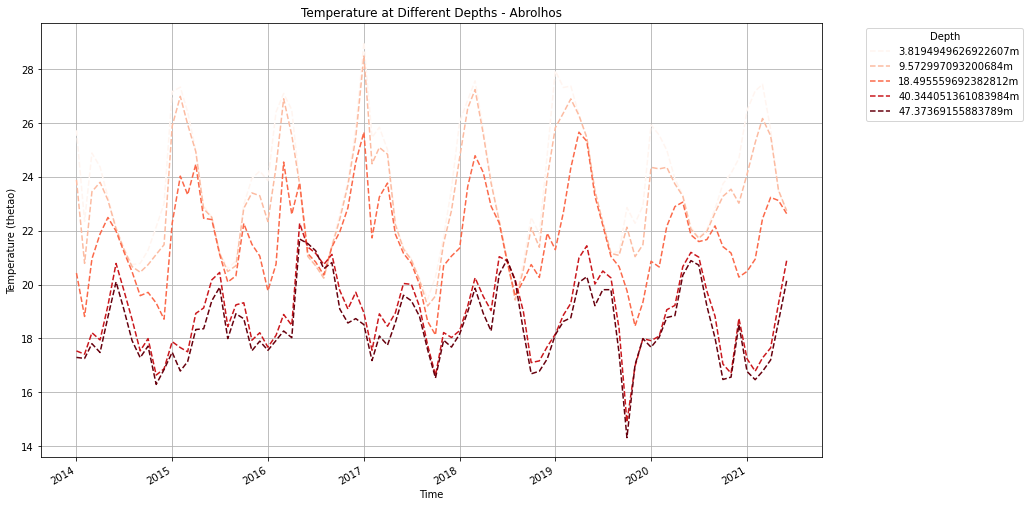

In [85]:
# Configurar a figura
plt.figure(figsize=(14, 8))

# Profundidades reais correspondentes aos índices
depth_indices = [2, 6, 10, 15, 16]
depths = sp_subset['depth'].isel(depth=depth_indices).values
colors = plt.cm.Reds(np.linspace(0, 1, len(depth_indices)))  # Cores para variação de temperatura

# Iterar sobre as profundidades e plotar em um único gráfico
for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
    sp_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(
        label=f'{depth}m', color=color, linestyle='--')

# Configurar o gráfico
plt.title('Temperature at Different Depths - SP')
plt.xlabel('Time')
plt.ylabel('Temperature (thetao)')
plt.grid(True)

# Colocar a legenda fora da figura
plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar o gráfico
plt.show()

#### Plote aqui a salinidade

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Configurar a figura
# plt.figure(figsize=(14, 8))

# # Profundidades reais correspondentes aos índices
# depth_indices = [0, 5, 10, 15, 20, 24]
# depths = nemo['depth'].isel(depth=depth_indices).values
# colors = plt.cm.PuBu(np.linspace(0, 1, len(depth_indices)))  # Gera uma lista de cores

# # Iterar sobre as profundidades e plotar em um único gráfico
# for i, (index, depth, color) in enumerate(zip(depth_indices, depths, colors)):
#     nemo['so'].isel(depth=index).mean(dim=['latitude', 'longitude']).plot(label=f'{depth}m',
#                                                                           color=color, linestyle='-')

# # Configurar o gráfico
# plt.title('Salinity at Different Depths')
# plt.xlabel('Time')
# plt.ylabel('Salinity (so)')
# plt.grid(True)

# # Colocar a legenda fora da figura
# plt.legend(title='Depth', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()


### Exportar em .csv os valores de temperatura entre depth min and max em cada site

In [ ]:
# Selecionar as profundidades e criar um DataFrame para armazenar os dados
depth_indices = [0, 5, 7, 10, 13, 16]
depths = acabo_subset['depth'].isel(depth=depth_indices).values
df = pd.DataFrame()

# Iterar sobre as profundidades e adicionar os dados de temperatura ao DataFrame
for index, depth in zip(depth_indices, depths):
    # Extrair a temperatura média para a profundidade selecionada
    temp_data = acabo_subset['thetao'].isel(depth=index).mean(dim=['latitude', 'longitude']).to_pandas()
    df[f'Temperature_{depth}m'] = temp_data

# Adicionar a coluna de tempo (index)
df['Time'] = temp_data.index

# Verificar o DataFrame
print(df)

# Exportar o DataFrame para um arquivo CSV
df.to_csv('/mnt/data/temperature_arraial_do_cabo.csv', index=False)


In [ ]:
# # Iterar sobre os subsets
# for local, subset in subsets.items():
#     # Extrair a variável de temperatura (thetao) e criar um DataFrame
#     df = subset['thetao'].to_dataframe().reset_index()

#     # Exportar para CSV
#     df.to_csv(f'{local}_temperature_depths.csv', index=False)

#     print(f"Dados exportados para {local}_temperature_depths.csv")

## Vamos aqui plotar uma seção vertical dos dados

1.Verifique as Profundidades Disponíveis:


In [ ]:
print(nemo['depth'])


2. Selecionar uma Localização para a Seção:

Escolha uma latitude e longitude específicas para criar a seção vertical, neste exemplo vamos escolher as coordenadas aproximadas de arraial do cabo

In [ ]:
lat_sel = nemo['latitude'].sel(latitude=chosen_lat)
lon_sel = nemo['longitude'].sel(longitude=chosen_lon)


3. Criar a Seção Vertical:
Selecione a temperatura ao longo da profundidade para o ponto escolhido:

In [ ]:
temp_section = nemo['thetao'].sel(latitude=lat_sel, longitude=lon_sel)


4. Plotar a Seção Vertical:


In [ ]:
temp_section.plot(y='depth', yincrease=False)  # yincrease=False para mostrar profundidade crescente para baixo
plt.show()


5. Plotar uma Seção Ao Longo de uma Linha (transecto):

Se quiser criar uma seção ao longo de uma linha (por exemplo, de uma latitude para outra):

#### temp_transect = nemo['thetao'].sel(longitude=chosen_lon).mean(dim='time')
temp_transect.plot(x='latitude', y='depth', yincrease=False)
plt.show()
